<h6>Project 1 - Building Reinforcement Learning Environment</h6>
<small>By: Bipul Kumar</small>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Global Configurations

**Environment**

<h6>Deterministic and Stochastic</h6>
<p>based on environmtnt paramater; Environment can be either deterministic or stochastic</p>
<p></p>

In [2]:
class Environment():
  def __init__(self, size=5, stochastic=False):
    self.size = size
    self.observations = np.zeros((self.size, self.size))
    self.actions = np.arange(4) #["up", "down", "left", "right"]
    self.max_timesteps = size*2 + 1
    self.stochastic = stochastic

    # State transition table
    self.transition_matrix = []
    for x in range(size + 1):
        state_x = []
        for y in range(size + 1):
            state_y = []
            for a in range(4):
                one_hot = np.zeros(4)
                one_hot[a] = 1
                state_y.append(one_hot)
            state_x.append(state_y)
        self.transition_matrix.append(state_x)
#     print(np.asarray(self.transition_matrix))
        
  def transition_func(self, x, y, action, return_probs=False):
      probs = self.transition_matrix[x][y][action]
      if return_probs:
          return probs
      else:
          return np.random.choice(len(probs), p=probs)

  def step(self, action):
    # import pdb
    # pdb.set_trace()
    if self.stochastic:
      action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
    else:
      action_taken = action

    #["up", "down", "left", "right"]
    if action_taken == 1:
        self.agent_pos[0] += 1
    elif action_taken == 0:
        self.agent_pos[0] -= 1
    elif action_taken == 3:
        self.agent_pos[1] += 1
    elif action_taken == 2:
        self.agent_pos[1] -= 1
      
    self.agent_pos = np.clip(self.agent_pos, 0, self.size-1)
    self.state = np.zeros((self.size, self.size))

    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.block_pos)] = 0.3
    
    #Rewards
    if np.array_equiv(self.agent_pos, self.goal_pos):
        reward = 10
        done = True
    elif np.array_equiv(self.agent_pos, self.block_pos):
        reward = -10
        done = True
    else:
        reward = -1
        done = False

    return self.agent_pos, reward, done

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [self.size-1, self.size-1]
    self.block_pos = [2, 2]
    self.state = np.zeros((self.size, self.size))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.block_pos)] = 0.3
    return np.array(self.agent_pos)/1.

  def render(self):
    plt.figure()
    plt.imshow(self.state)


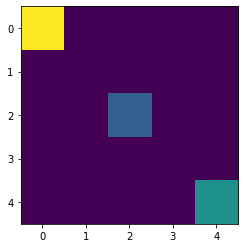

In [3]:
env = Environment()
env.reset()
env.render()

**Tabular methood - SARSA**


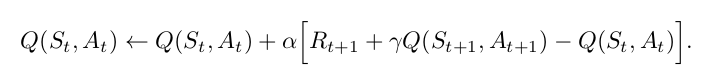

In [4]:
class SARSA_Agent():
  def __init__(self, environment, expected):
    self.environment = environment
    self.actions = environment.actions
    self.expected = expected
    #Hyper parameters
    self.epsilon = 1.0
    self.learning_rate = 0.1
    self.gamma = 0.99
    #Q-table
    self.q_table = np.zeros((environment.size, environment.size, len(environment.actions)))

  def step(self, observation):
    if np.random.uniform(0, 1) < self.epsilon:
      # select random action
      action = np.random.choice(self.actions, 1)[0]
    else:
      # action with max reward
      action = np.argmax(self.q_table[observation[0], observation[1], :])
    return action

  def update(self, state, action, reward, next_state):
    state = state.astype(int)
    action = action.astype(int)
    next_state = next_state.astype(int)
    # Update Q-table
    # print(state, action, next_state)
    if(not self.expected):
      self.q_table[state[0], state[1], action] = self.q_table[state[0], state[1], action] + self.learning_rate * (reward + self.gamma * (self.q_table[next_state[0], next_state[1], action]) - self.q_table[state[0], state[1], action] )
    else:
      self.q_table[state[0], state[1], action] = self.q_table[state[0], state[1], action] + self.learning_rate * (reward + self.gamma * np.mean(self.q_table[next_state[0], next_state[1], :]) - self.q_table[state[0], state[1], action] )
  def set_epsilon(self, epsilon):
    self.epsilon = epsilon


**Training in stochastic environment**

In [5]:
environment = Environment(stochastic=True)
agent = SARSA_Agent(environment, False)
episodes = 500

total_rewards = []
epsilons = [agent.epsilon]

for episode in range(episodes):
  obs = environment.reset()
  done = False
  r = 0

  while not done:
    current_state = obs.copy()
    action = agent.step(current_state.astype(int))
    obs, reward, done = environment.step(action)
    agent.update(current_state, action, reward, obs)
    r += reward
  agent.set_epsilon(max(0.005, agent.epsilon*0.99)) # decay epsilon
  epsilons.append(agent.epsilon)
  total_rewards.append(r)

[[[-6.67055406 -5.56022984 -5.73210588 -5.56021991]
  [-4.7842214  -4.63907613 -4.89565824 -4.6064393 ]
  [-3.82680573 -5.35219843 -4.10634853 -3.64290262]
  [-2.85976304 -2.72847343 -2.97340268 -2.66960281]
  [-1.58805582  6.73288573 -1.99442961 -1.68646776]]

 [[-5.95818012 -4.60643543 -4.68891031 -4.63154975]
  [-4.06512783 -3.97308766 -4.08731926 -3.96764864]
  [-3.35195603 -6.5132156  -3.2004848  -3.20867342]
  [-2.56824016 -2.46379283 -2.63311234 -2.41010345]
  [-1.45928859  7.81099963 -2.03207222 -1.58805582]]

 [[-4.45216247 -3.64290065 -4.01905595 -7.51688192]
  [-3.43616865 -3.41858376 -3.40874674 -8.49905365]
  [ 0.          0.          0.          0.        ]
  [-2.06362954 -2.07354994 -6.12579511 -2.05688679]
  [-1.65971904  8.89999997 -5.33169486 -1.88299651]]

 [[-3.67318967 -2.66960265 -3.05394637 -2.74467585]
  [-2.74940992 -2.68811692 -2.81987516 -2.70923236]
  [-4.0951     -2.13951218 -2.10645828 -2.13315485]
  [-1.77499487 -1.78702233 -1.85989416 -1.74769238]
  [-1.

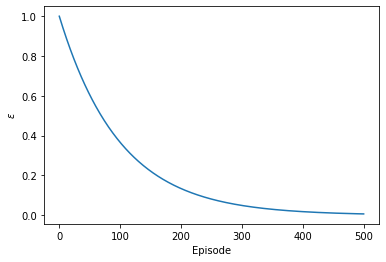

In [6]:
print(agent.q_table)
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

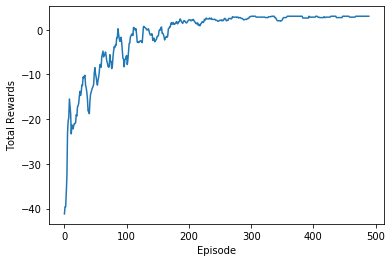

In [7]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

**Testing**


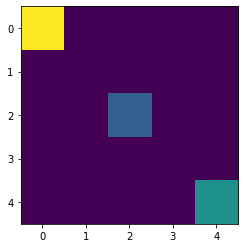

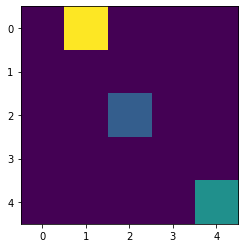

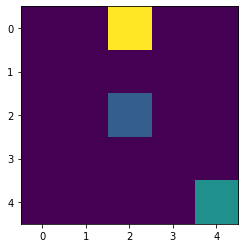

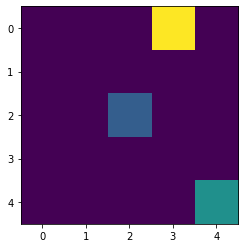

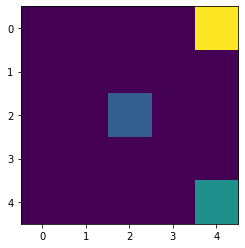

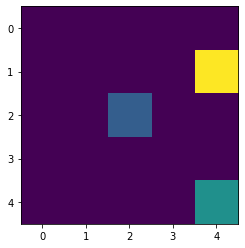

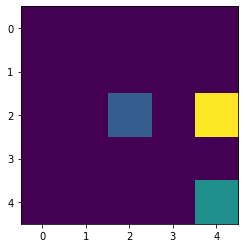

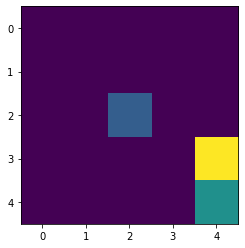

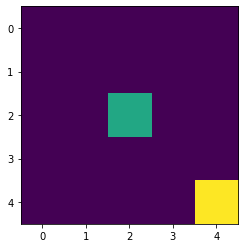

In [8]:
env = Environment()
obs = env.reset()
done = False
env.render()
plt.show()

while not done:
  action = agent.step(obs.astype(int))
  current_state = obs.copy()
  # print(action, done, obs)
  obs, reward, done = env.step(action)
  env.render()
  plt.show()

**Training deterministic environment**

In [9]:
deterministic_environment = Environment(stochastic=False)
sarsa_agent = SARSA_Agent(deterministic_environment, False)
episodes = 500

total_rewards = []
epsilons = [sarsa_agent.epsilon]

for episode in range(episodes):
  obs = deterministic_environment.reset()
  done = False
  r = 0

  while not done:
    current_state = obs.copy()
    action = sarsa_agent.step(current_state.astype(int))
    obs, reward, done = deterministic_environment.step(action)
    sarsa_agent.update(current_state, action, reward, obs)
    r += reward
  sarsa_agent.set_epsilon(max(0.005, sarsa_agent.epsilon*0.99)) # decay epsilon
  epsilons.append(sarsa_agent.epsilon)
  total_rewards.append(r)

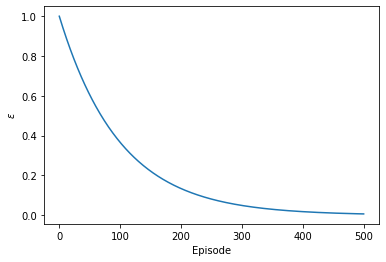

In [10]:
# print(agent.q_table)
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)


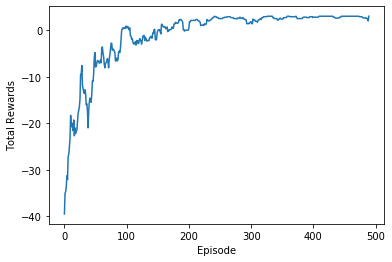

In [11]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

**Test - Deterministic Environment**

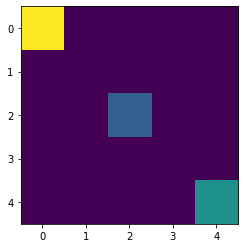

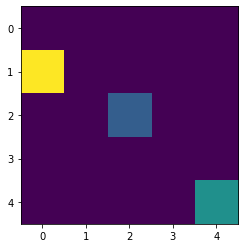

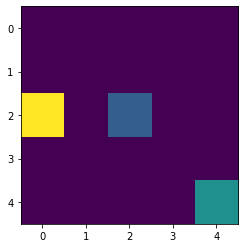

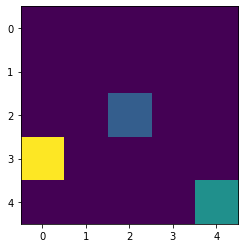

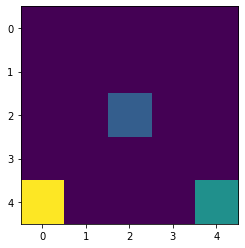

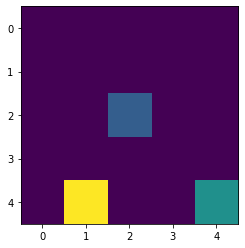

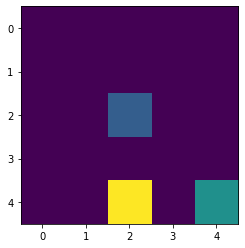

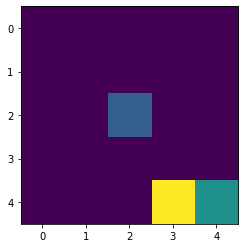

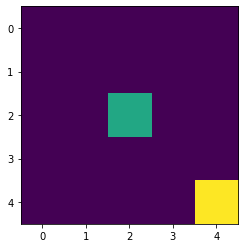

In [12]:
env = Environment()
obs = env.reset()
done = False
env.render()
plt.show()

while not done:
  action = sarsa_agent.step(obs.astype(int))
  current_state = obs.copy()
  # print(action, done, obs)
  obs, reward, done = env.step(action)
  env.render()
  plt.show()